In [1]:
import torchvision as tv
from matplotlib import pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
import sys
import os
import torch

In [2]:
torch.manual_seed(0)
np.random.seed(0)
path2add = os.path.abspath('..')
if path2add not in sys.path:
    sys.path.append(path2add)

In [3]:
from torchvision import tv_tensors
from torchvision.transforms import v2

In [4]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomPhotometricDistort(p=1),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)
type(transforms)

torchvision.transforms.v2._container.Compose

In [5]:
from maskaugfish.augmentation import generate_channel_switch

In [6]:
image_path = "..\\data\\fish_image\\fish_01\\fish_000000009598_05281.png"
mask_path = "..\\data\\mask_image\\mask_01\\mask_000000009598_05281.png"

In [7]:
image = tv.io.decode_image(image_path)
mask = tv.io.decode_image(mask_path)
print(image.shape)
print(mask.shape)

torch.Size([3, 112, 104])
torch.Size([1, 112, 104])


In [8]:
choices, p_choices = generate_channel_switch(prob=1.0)
print(choices)
print(p_choices)

[Lambda(<lambda>, types=['object']), Lambda(<lambda>, types=['object']), Lambda(<lambda>, types=['object']), Lambda(<lambda>, types=['object']), Lambda(<lambda>, types=['object']), Lambda(<lambda>, types=['object'])]
[0.0, 0.2, 0.2, 0.2, 0.2, 0.2]


In [9]:
transform_1 = tv.transforms.v2.RandomChoice(choices, [0, 1, 0, 0, 0, 0])
transform_2 = tv.transforms.v2.RandomChoice(choices, [0, 0, 1, 0, 0, 0])
transform_3 = tv.transforms.v2.RandomChoice(choices, [0, 0, 0, 1, 0, 0])
transform_4 = tv.transforms.v2.RandomChoice(choices, [0, 0, 0, 0, 1, 0])
transform_5 = tv.transforms.v2.RandomChoice(choices, [0, 0, 0, 0, 0, 1])

In [10]:
def show_image(img, title="Image"):
    plt.imshow(tv.transforms.functional.to_pil_image(img))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [11]:
image_list = [image,
              transform_1(image),
              transform_2(image),
              transform_3(image),
              transform_4(image),
              transform_5(image)]

In [12]:

grid = tv.utils.make_grid(image_list, nrow=6)


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

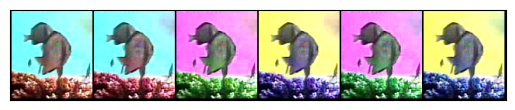

In [13]:
show(grid)

In [14]:
from maskaugfish.augmentation import addition_transform

In [15]:
image_list = [image]
for value in [-75, -25, 25, 75]:
    transform = addition_transform(prob=1,
                                   value=value)
    augmented_image = transform(image)
    image_list.append(augmented_image)

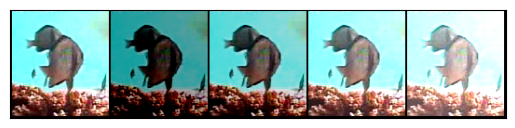

In [16]:
grid = tv.utils.make_grid(image_list, nrow=5)
show(grid)

In [17]:
mask

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [18]:
switch_mask = ((mask + 1) * 255)
print(switch_mask)

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)


In [19]:
def region_transform(image: torch.Tensor,
                     mask: torch.Tensor,
                     transform: v2.Compose) -> torch.Tensor:
    original_image = image.clone()
    transformed_image = transform(image)
    return torch.where(mask.bool(), transformed_image, original_image)

In [20]:
# Fish-only augmentation
image_list = [image,
              transform_2(image),
              torch.cat([mask] * 3, dim=0),]

In [21]:

image_list.append(region_transform(image, mask, transform_2))
image_list.append(region_transform(image, switch_mask, transform_2))

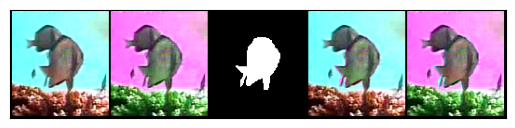

In [22]:
grid = tv.utils.make_grid(image_list, nrow=6)
show(grid)